In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(2, .5, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#holdings fiat
h = sts.expon.rvs( loc=100,scale=1000, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([36., 30.,  9., 15.,  2.,  3.,  1.,  2.,  0.,  2.]),
 array([ 1.04141196,  3.82813124,  6.61485053,  9.40156981, 12.1882891 ,
        14.97500838, 17.76172766, 20.54844695, 23.33516623, 26.12188551,
        28.9086048 ]),
 <a list of 10 Patch objects>)

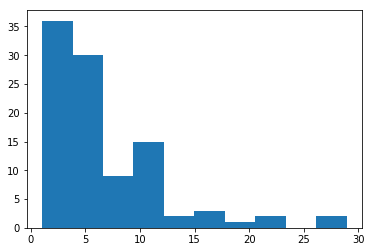

In [4]:
plt.hist(gamma)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'actions': {},
 'funds': 50000.0,
 'holdings': array([ 282.63545304,  136.7389098 , 3138.07335652,  981.28376369,
        2906.21681467,  264.97574521, 1004.95498987,  345.25506406,
         629.919472  , 1026.71659708, 3496.50721903,  135.04636557,
         641.46232263,  246.44196565, 2089.32058936,  184.83270219,
        2821.03030926, 1169.32324036,  626.72522603, 1944.22414317,
         434.44329778,  389.8230516 ,  405.782934  ,  640.8370886 ,
         615.0064134 ,  394.4329894 , 1554.72045835, 2239.4879189 ,
        1825.58153935,  172.56683069, 2801.71212732,  138.17422388,
         257.82357911, 1079.20507087, 1174.67069012, 1272.79255728,
         339.62943481, 3259.54671374,  262.76927555, 1875.54418147,
        2773.26348672,  335.20392394,  630.64451682, 1626.62508183,
         228.76436205, 1806.83656097, 2482.82315863, 2666.55839065,
         377.34543697,  452.16604752,  253.49029494, 2594.61379587,
         762.94188172,  398.04965375,  379.60934133, 2247.24348151,
 

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    #if delF <1:
    #    if s['funds'] <1000:
    #        delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 5000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 5000), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([1.41151501, 1.38219589, 1.19520762, 1.20803678, 1.1626232 ,
       2.77050087, 1.10469473, 1.85291014, 2.09665945, 2.07490085,
       3.07972937, 1.3591671 , 2.81199389, 2.04401458, 2.58186449,
       1.36114227, 1.63021917, 2.21212879, 1.55398853, 2.11247388,
       1.55836769, 1.79946493, 1.02137126, 0.89042514, 1.80577178,
       1.53531329, 2.8123043 , 2.91236742, 1.85760469, 1.53665798,
       2.13862541, 2.40820235, 2.47849544, 2.57956379, 0.88971535,
       2.20409656, 1.6591847 , 1.83073833, 2.33926571, 1.55721901,
       2.2626349 , 1.6850749 , 2.00097051, 1.89151162, 1.88781355,
       2.5285497 , 2.45555209, 1.38659493, 2.15307961, 1.96474893,
       1.72749753, 2.11372884, 1.95294003, 2.09856037, 1.87495445,
       0.99198196, 2.00969397, 2.32107739, 1.43069004, 2.35366984,
       1.94558716, 2.0596508 , 1.76320517, 2.64372713, 2.26488638,
       1.88429352, 1.21026849, 2.54659831, 2.4041932 , 2

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a136f2c18>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a136f2c18>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

In [21]:
df.head()

,actions,funds,holdings,prices,reserve,run,spot_price,substep,supply,timestep,tokens
0,{},50000.000000,"[282.63545303852584, 136.73890979910675, 3138....","[0.07057575044967453, 0.06910979439987164, 0.0...",50000.000000,1,0.100000,0,1000000.000000,0,"[6230.983620848502, 8232.907617271383, 11329.7..."
1,{},50305.518428,"[282.63545303852584, 136.73890979910675, 3138....","[0.07057575044967453, 0.06910979439987164, 0.0...",50000.000000,1,0.100000,1,1000000.000000,1,"[6230.983620848502, 8232.907617271383, 11329.7..."
2,"[{'agent': 41, 'mech': 'burn', 'amt': 24280.16...",50305.518428,"[282.63545303852584, 136.73890979910675, 3138....","[0.07057575044967453, 0.06910979439987164, 0.0...",50000.000000,1,0.100000,2,1000000.000000,1,"[6230.983620848502, 8232.907617271383, 11329.7..."
3,"[{'agent': 41, 'mech': 'burn', 'amt': 24280.16...",51090.564881,"[282.63545303852584, 854.766924779869, 3138.07...","[0.07057575044967453, 0.06910979439987164, 0.0...",49434.207904,1,0.099433,3,994325.981797,1,"[6230.9836208485, 0.0, 11329.772586345014, 0.0..."
4,"[{'agent': 41, 'mech': 'burn', 'amt': 24280.16...",50972.669330,"[282.63545303852584, 854.766924779869, 3138.07...","[0.07252661648939933, 0.0710201382509542, 0.06...",49434.207904,1,0.099433,1,994325.981797,2,"[6230.9836208485, 0.0, 11329.772586345014, 0.0..."


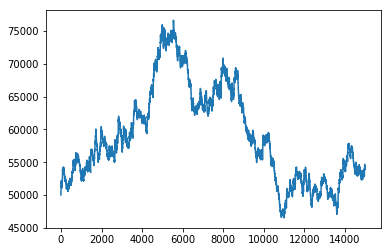

In [22]:
df.funds.plot()

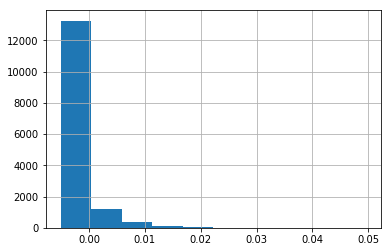

In [23]:
(df.funds.diff()/df.funds).hist()

In [24]:
rdf = df[df.substep == 3].copy()

In [25]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [26]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [27]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [28]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

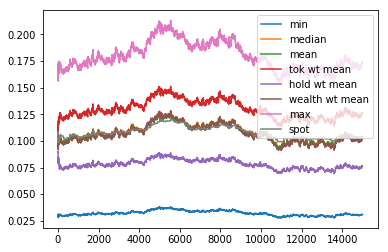

In [29]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

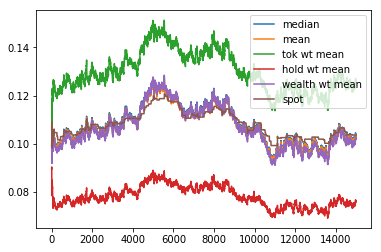

In [30]:
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.spot_price.plot()
plt.legend(['median','mean','tok wt mean','hold wt mean','wealth wt mean', 'spot'])

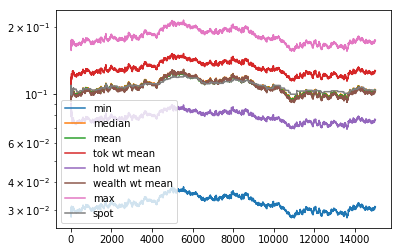

In [31]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [32]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

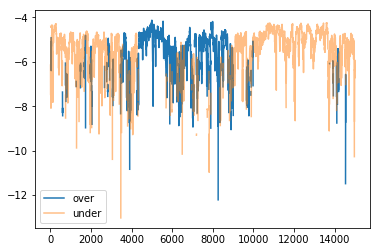

In [33]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [34]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

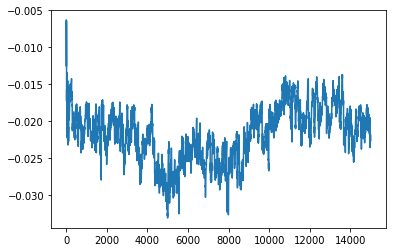

In [35]:
rdf.est_err.plot()

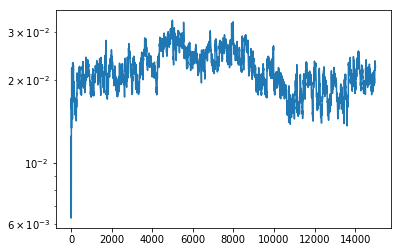

In [36]:
rdf.est_err.apply(np.abs).plot(logy=True)

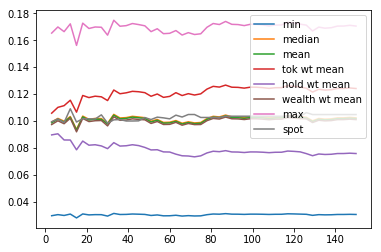

In [37]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

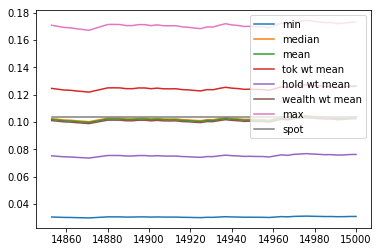

In [38]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [39]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [40]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [41]:
ind=tdf[tdf.amt==0].index
tdf.drop(ind, inplace=True)
sdf.drop(ind, inplace=True)

In [42]:
txdf = sdf.merge(tdf, right_index=True, left_index=True)

In [43]:
txdf.head()

,F,P,R,S,a,h_a,s_a,agent,amt,mech,pbar
0,50425.445431,0.097572,47601.459942,975719.836247,41,2613.816979,0.000000,41,2.428016e+04,burn,0.093847
1,50497.516987,0.096083,46160.028826,960833.271965,71,4457.725833,0.000000,71,1.488656e+04,burn,0.091986
2,50594.143233,0.094051,44227.503901,940505.224874,75,2549.262392,0.000000,75,2.032805e+04,burn,0.090314
3,50691.880582,0.091949,42272.756916,919486.344829,6,2861.964625,0.000000,6,2.101888e+04,burn,0.088350
4,50691.880582,0.091949,42272.756916,919486.344829,62,1031.064228,5246.851043,62,1.251688e-08,burn,0.088356


In [44]:
emas = ['P', 'pbar']
for com in [2,4,8,16]:
    k = 'pbar_ewma'+str(com)
    emas.append(k)
    txdf[k] = txdf.pbar.ewm(com).mean()

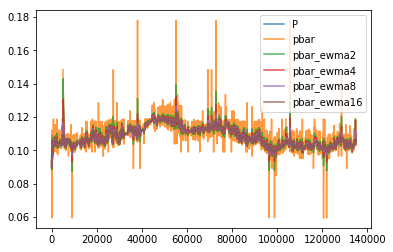

In [45]:
txdf[emas].plot(alpha=.8)

[0, 3000, 0.095, 0.115]

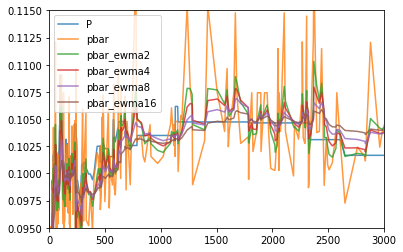

In [46]:
txdf[emas].plot(alpha=.8)
plt.axis([0, 3000, .095, .115])

In [47]:
txdf['dP'] = txdf.P.diff()
txdf['percent_dP'] = txdf.P.pct_change().apply(abs)

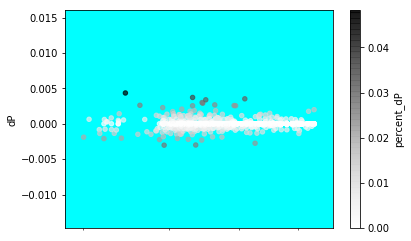

In [48]:
txdf.plot.scatter(x='R', y='dP', c='percent_dP', alpha=.7, logx=True)
plt.gca().set_facecolor('cyan') 

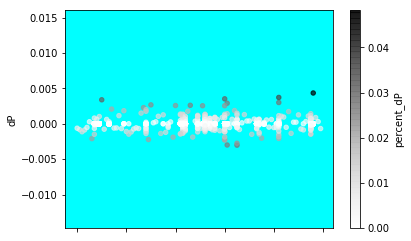

In [49]:
txdf.plot.scatter(x='a',y='dP', c='percent_dP', alpha=.7)
plt.gca().set_facecolor('cyan') 

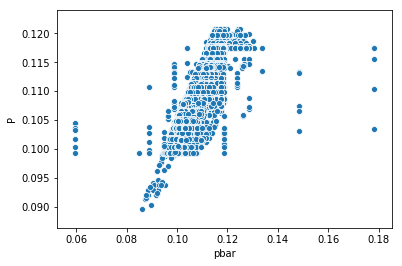

In [50]:
sns.scatterplot(x="pbar", y="P", data=txdf) 

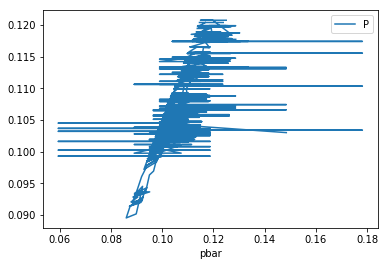

In [95]:
txdf.plot(x='pbar',y='P')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


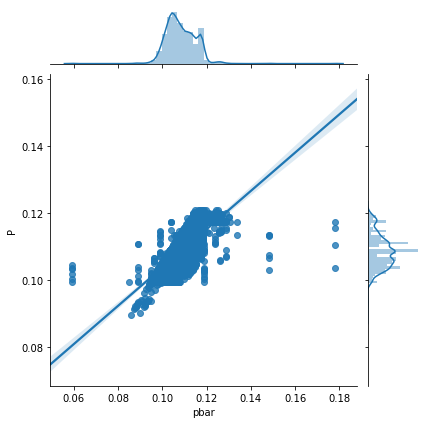

In [93]:
sns.jointplot(x="pbar", y="P",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all")) 

In [97]:
txdf['P_err'] = txdf.P-txdf.pbar

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


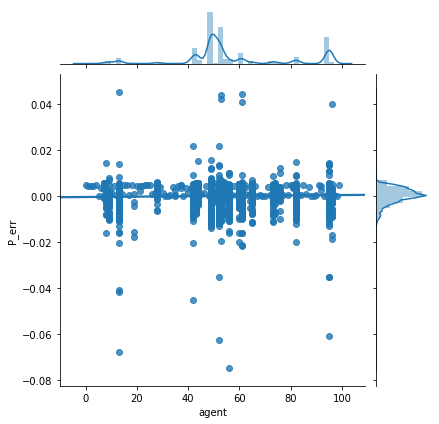

In [98]:
sns.jointplot(x="agent", y="P_err",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all")) 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


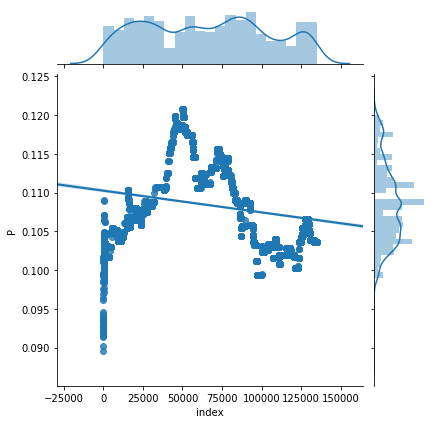

In [100]:
sns.jointplot(x='index',y="P",kind="reg", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

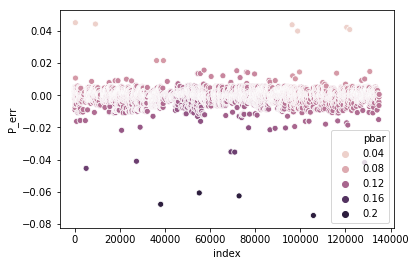

In [103]:
sns.scatterplot(x='index',y="P_err", hue = "pbar", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

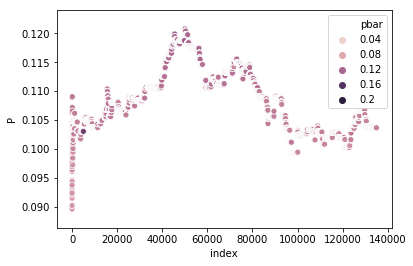

In [109]:
sns.scatterplot(x='index',y="P", hue = "pbar", data=txdf.replace([np.inf, -np.inf], np.nan).dropna(how="all").reset_index()) 

In [51]:
tx_summary=tdf[['agent','mech','pbar','amt']].groupby(['agent','mech']).agg(['median','count']).T.iloc[:-1].T

In [52]:
tx_summary

pbar                   amt
              median   count        median
agent mech                                
0     burn  0.095623     1.0  6.230984e+03
1     burn  0.087214     1.0  8.232908e+03
2     burn  0.092894     1.0  1.132977e+04
3     burn  0.089187     1.0  8.745962e+03
4     burn  0.094700     1.0  5.200334e+03
5     bond  0.093585     1.0  2.649757e+02
6     burn  0.088350     1.0  2.101888e+04
7     bond  0.114641     1.0  9.231311e+02
      burn  0.111829    21.0  6.697996e-09
8     bond  0.099740     9.0  1.105946e-10
      burn  0.104362    13.0  5.645150e-10
9     bond  0.100937    16.0  2.419256e-10
      burn  0.103361    83.0  3.345798e-10
10    bond  0.103239     1.0  3.496507e+03
11    burn  0.087845     1.0  7.690380e+03
12    bond  0.104465     1.0  6.414623e+02
13    bond  0.103356    43.0  2.695742e-10
      burn  0.103862   176.0  6.261438e-10
14    bond  0.100677     1.0  2.089321e+03
15    burn  0.096339     1.0  6.100548e+03
16    burn  0.096228     1.0  5.849735e+03
17    bond  0.101929     1.0  1.169323e+03
18    burn  0.097569     1.0  6.836172e+03
19    bond  0.118750     3.0  6.912160e-11
      burn  0.107042     2.0  6.457418e-10
20    burn  0.097101     1.0  1.084869e+04
21    burn  0.093592     2.0  7.336186e+03
22    burn  0.096934     1.0  1.155001e+04
23    burn  0.096818     1.0  7.359922e+03
24    burn  0.096697     1.0  5.762642e+03
...              ...     ...           ...
74    burn  0.116833    33.0  1.527098e-09
75    burn  0.090314     1.0  2.032805e+04
76    bond  0.098958     9.0  6.220944e-11
      burn  0.103024     9.0  4.141506e-10
77    bond  0.094051     1.0  5.038025e+02
78    burn  0.096361     1.0  4.739317e+03
79    bond  0.100086     1.0  6.057811e+02
80    burn  0.095201     1.0  5.364865e+03
81    burn  0.095312     3.0  9.500299e-09
82    bond  0.103642    42.0  6.151822e-10
      burn  0.104951   240.0  1.207330e-09
83    bond  0.098268     1.0  1.059011e+03
84    bond  0.101112     1.0  9.567733e+02
85    burn  0.096598     1.0  5.002826e+03
86    bond  0.099670     1.0  1.720954e+03
87    burn  0.089172     1.0  1.356738e+04
88    bond  0.102475     1.0  2.305358e+02
89    bond  0.101501     1.0  2.307161e+02
90    bond  0.103529     1.0  1.302401e+03
91    burn  0.097848     1.0  7.391530e+03
92    burn  0.092944     2.0  4.334518e+03
93    bond  0.101915     1.0  3.244852e+02
94    bond  0.100093     1.0  1.092874e+03
95    bond  0.110495    66.0  9.538780e-10
      burn  0.107753  1014.0  1.541549e-09
96    bond  0.102257    17.0  1.036824e-10
      burn  0.103602    29.0  6.697412e-10
97    bond  0.098992     1.0  8.729285e+02
98    bond  0.099488     1.0  2.999926e+02
99    burn  0.097137     1.0  6.769772e+03

[126 rows x 3 columns]

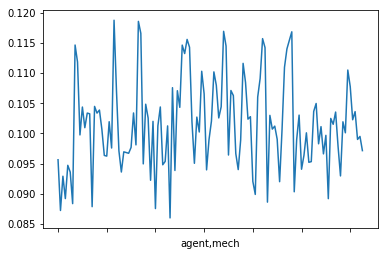

In [53]:
tx_summary.pbar['median'].plot()

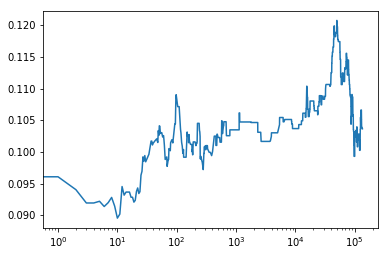

In [54]:
sdf['P'].plot(logx=True)

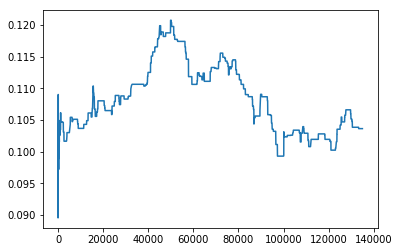

In [55]:
sdf['P'].plot()

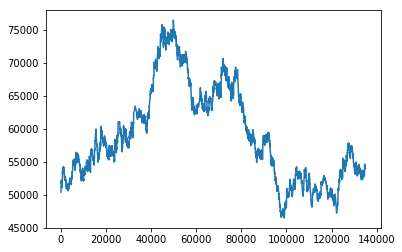

In [56]:
sdf.F.plot()

In [57]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

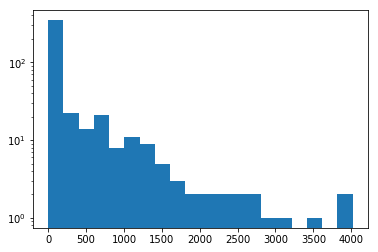

In [58]:
plt.hist(bond_amts, bins=20)
plt.yscale('log')

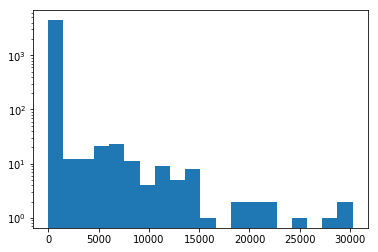

In [59]:
plt.hist(burn_amts, bins=20)
plt.yscale('log')

In [60]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

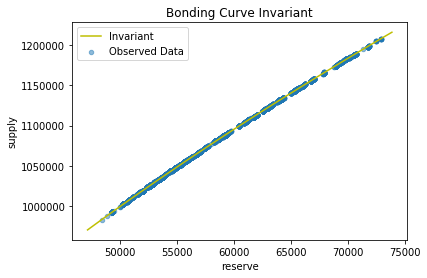

In [61]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

In [62]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([51.,  8., 11., 10.,  2.,  5.,  5.,  4.,  1.,  3.]),
 array([   0.        ,  460.13499058,  920.26998116, 1380.40497174,
        1840.53996232, 2300.6749529 , 2760.80994348, 3220.94493406,
        3681.07992464, 4141.21491522, 4601.3499058 ]),
 <a list of 10 Patch objects>)

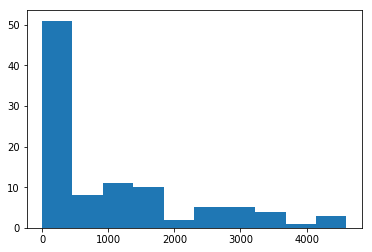

In [63]:
plt.hist(rdf.iloc[-1].holdings)

In [64]:
rdf['gini_h'] = rdf.holdings.apply(gini)

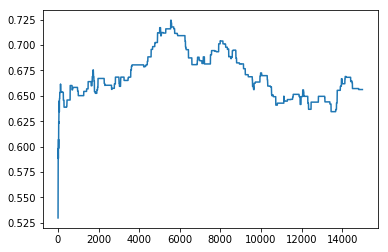

In [65]:
rdf.gini_h.plot()

(array([49.,  6., 13., 11.,  5.,  6.,  6.,  2.,  0.,  2.]),
 array([    0.        ,  4902.60228286,  9805.20456572, 14707.80684857,
        19610.40913143, 24513.01141429, 29415.61369715, 34318.21598   ,
        39220.81826286, 44123.42054572, 49026.02282858]),
 <a list of 10 Patch objects>)

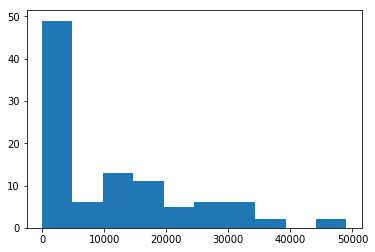

In [66]:
plt.hist(rdf.iloc[-1].tokens)

In [67]:
rdf['gini_s'] = rdf.tokens.apply(gini)

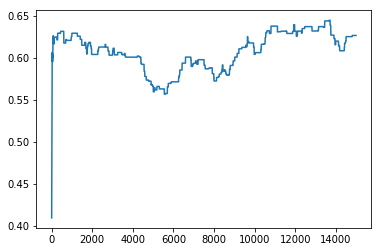

In [68]:
rdf.gini_s.plot()

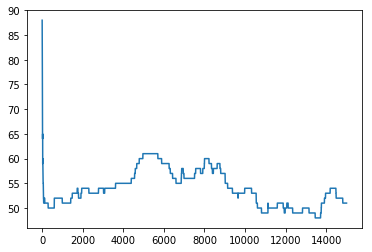

In [69]:
rdf.tokens.apply(np.count_nonzero).plot()

In [70]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([21., 26., 13.,  7., 11.,  7.,  8.,  3.,  2.,  2.]),
 array([ 718.88491668, 1155.17108514, 1591.4572536 , 2027.74342206,
        2464.02959051, 2900.31575897, 3336.60192743, 3772.88809589,
        4209.17426434, 4645.4604328 , 5081.74660126]),
 <a list of 10 Patch objects>)

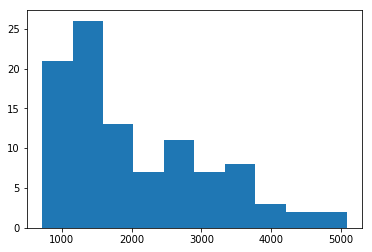

In [71]:
plt.hist(rdf.iloc[-1].asset_value)

In [72]:
rdf['gini'] = rdf.asset_value.apply(gini)

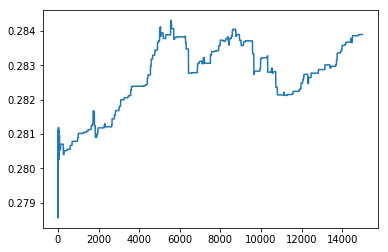

In [73]:
rdf.gini.plot()

In [74]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

([array([ 4., 11., 16., 32., 20., 15.,  2.]),
  array([ 4., 11., 16., 32., 20., 15.,  2.]),
  array([ 4., 11., 16., 32., 20., 15.,  2.]),
  array([ 4., 11., 17., 32., 20., 14.,  2.]),
  array([ 4., 11., 16., 32., 20., 15.,  2.]),
  array([ 4., 11., 16., 32., 20., 15.,  2.]),
  array([ 4., 11., 16., 32., 20., 15.,  2.])],
 array([-0.70396484, -0.50755172, -0.3111386 , -0.11472548,  0.08168764,
         0.27810076,  0.47451388,  0.670927  ]),
 <a list of 7 Lists of Patches objects>)

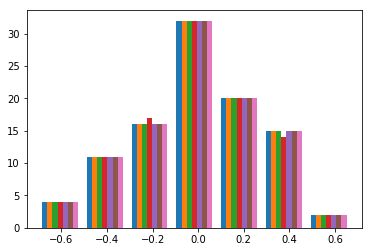

In [75]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)